In [13]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint
from math import floor
from skimage import io
from scipy.ndimage import gaussian_filter
from IPython.display import clear_output
from PIL import Image

def gkern(kern_size, nsig=3):
    interval = (2 * nsig + 1.) / kern_size
    x = np.linspace(-nsig - interval / 2., nsig + interval / 2., kern_size + 1)
    kern1d = np.diff(np.exp(-0.5 * x**2))
    kernel_raw = np.outer(kern1d, kern1d)
    return kernel_raw / kernel_raw.sum()

def loadExampleMap(exampleMapPath):
    exampleMap = io.imread(exampleMapPath)
    exampleMap = exampleMap / 255.0
    if exampleMap.shape[-1] > 3:
        exampleMap = exampleMap[:, :, :3]
    elif len(exampleMap.shape) == 2:
        exampleMap = np.repeat(exampleMap[:, :, np.newaxis], 3, axis=2)
    return exampleMap

def getNeighbourhood(mapToGetNeighbourhoodFrom, kernelSize, row, col):
    halfKernel = floor(kernelSize / 2)
    if mapToGetNeighbourhoodFrom.ndim == 3:
        npad = ((halfKernel, halfKernel), (halfKernel, halfKernel), (0, 0))
    else:  # for 2D arrays like filledMap
        npad = ((halfKernel, halfKernel), (halfKernel, halfKernel))
    paddedMap = np.pad(mapToGetNeighbourhoodFrom, npad, 'constant', constant_values=0)
    row_start = row
    row_end = row + 2 * halfKernel + 1
    col_start = col
    col_end = col + 2 * halfKernel + 1
    return paddedMap[row_start:row_end, col_start:col_end]

def initCanvas(exampleMap, size):
    imgRows, imgCols, imgChs = exampleMap.shape
    canvas = np.zeros((size[0], size[1], imgChs)) 
    filledMap = np.zeros((size[0], size[1]))  
    margin = 1
    rand_row = randint(margin, imgRows - margin - 1)
    rand_col = randint(margin, imgCols - margin - 1)
    exampleMap_patch = exampleMap[rand_row - margin:rand_row + margin + 1, rand_col - margin:rand_col + margin + 1]
    center_row = floor(size[0] / 2)
    center_col = floor(size[1] / 2)
    canvas[center_row - margin:center_row + margin + 1, center_col - margin:center_col + margin + 1] = exampleMap_patch
    filledMap[center_row - margin:center_row + margin + 1, center_col - margin:center_col + margin + 1] = 1
    return canvas, filledMap

def prepareExamplePatches(exampleMap, searchKernelSize):
    imgRows, imgCols, imgChs = exampleMap.shape
    num_horiz_patches = imgRows - (searchKernelSize - 1)
    num_vert_patches = imgCols - (searchKernelSize - 1)
    examplePatches = np.zeros((num_horiz_patches * num_vert_patches, searchKernelSize, searchKernelSize, imgChs))
    for r in range(num_horiz_patches):
        for c in range(num_vert_patches):
            examplePatches[r * num_vert_patches + c] = exampleMap[r:r + searchKernelSize, c:c + searchKernelSize]
    return examplePatches

def findMatches(template, examplePatches, validMask, gaussMask):
    template = np.repeat(template[np.newaxis, :, :, :], examplePatches.shape[0], axis=0)
    validMask = np.repeat(validMask[np.newaxis, :, :, :], examplePatches.shape[0], axis=0)
    gaussMask = np.repeat(gaussMask[np.newaxis, :, :, :], examplePatches.shape[0], axis=0)
    distances = np.sum(((examplePatches - template) ** 2) * validMask * gaussMask, axis=(1, 2, 3))
    min_distance = np.min(distances)
    best_matches = np.where(distances <= min_distance * (1 + 0.1))[0]
    return best_matches

def getBestCandidateCoord(filledMap):
    candidates = np.argwhere(filledMap == 0)
    np.random.shuffle(candidates)
    sorted_candidates = sorted(candidates, key=lambda x: -np.sum(filledMap[max(0, x[0] - 1):x[0] + 2, max(0, x[1] - 1):x[1] + 2]))
    return sorted_candidates[0]

def textureSynthesis(exampleMapPath, outputSize, searchKernelSize, savePath, snapshots=True):
    if searchKernelSize % 2 == 0:
        searchKernelSize += 1
    exampleMap = loadExampleMap(exampleMapPath)
    canvas, filledMap = initCanvas(exampleMap, outputSize)
    examplePatches = prepareExamplePatches(exampleMap, searchKernelSize)
    gaussMask = gkern(searchKernelSize)
    gaussMask = np.repeat(gaussMask[:, :, np.newaxis], 3, axis=2) 
    while np.sum(filledMap) < outputSize[0] * outputSize[1]:
        candidate_row, candidate_col = getBestCandidateCoord(filledMap)
        template = getNeighbourhood(canvas, searchKernelSize, candidate_row, candidate_col)
        validMask = getNeighbourhood(filledMap, searchKernelSize, candidate_row, candidate_col)
        validMask = np.repeat(validMask[:, :, np.newaxis], 3, axis=2)
        best_matches = findMatches(template, examplePatches, validMask, gaussMask)
        if len(best_matches) == 0:
            best_match = np.random.randint(0, len(examplePatches))
        else:
            best_match = best_matches[np.random.choice(len(best_matches))]
        chosenPixel = examplePatches[best_match, floor(searchKernelSize / 2), floor(searchKernelSize / 2)]
        canvas[candidate_row, candidate_col] = chosenPixel
        filledMap[candidate_row, candidate_col] = 1
        plt.imshow(canvas)
        clear_output(wait=True)
        plt.show()
        if snapshots:
            img = Image.fromarray((canvas * 255).astype(np.uint8))
            img.save(f'{savePath}/out{int(np.sum(filledMap))}.jpg')
    if not snapshots:
        img = Image.fromarray((canvas * 255).astype(np.uint8))
        img.save(f'{savePath}/out.jpg')
 


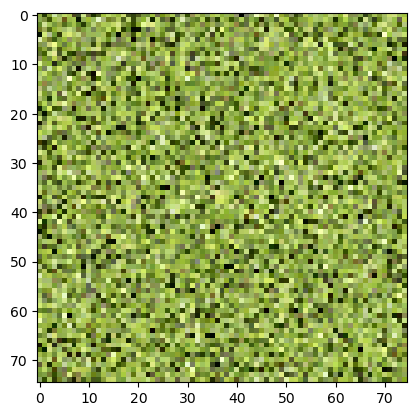

In [14]:
exampleMapPath = "C:/Users/amend/Downloads/1.jpg"
outputSize = [75,75]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,11,outputPath)

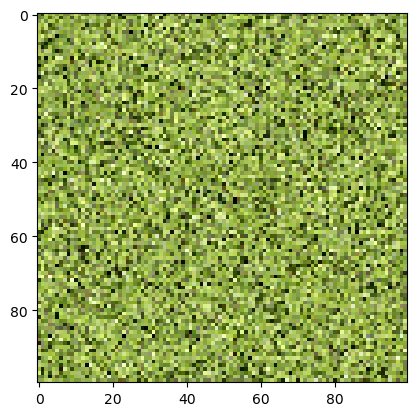

In [15]:
exampleMapPath = "C:/Users/amend/Downloads/7.png"
outputSize = [100,100]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,11,outputPath)

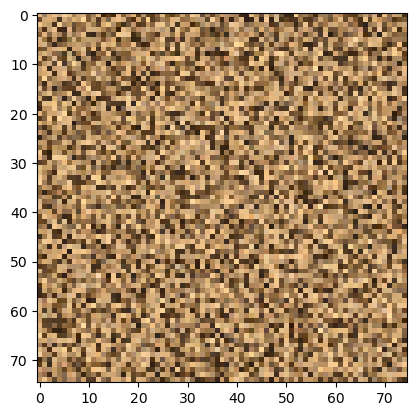

In [20]:
exampleMapPath = "C:/Users/amend/Desktop/7.png"
outputSize = [75,75]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,3,outputPath)

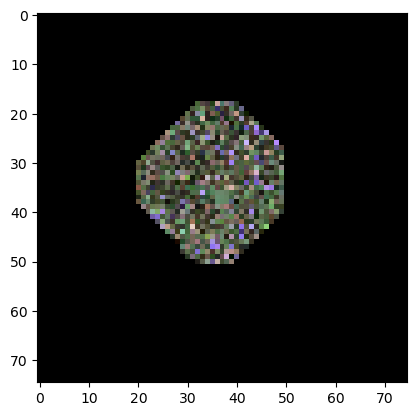

KeyboardInterrupt: 

In [21]:
exampleMapPath = "C:/Users/amend/Desktop/8.png"
outputSize = [75,75]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,11,outputPath)

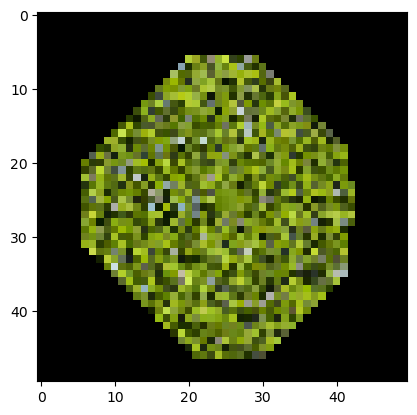

In [22]:
exampleMapPath = "C:/Users/amend/Desktop/9.png"
outputSize = [50,50]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,11,outputPath)

In [ ]:
exampleMapPath = "C:/Users/amend/Desktop/10.png"
outputSize = [75,75]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,11,outputPath)

In [ ]:
exampleMapPath = "C:/Users/amend/Desktop/11.png"
outputSize = [75,75]
outputPath = "C:/Users/amend/Desktop/result"
textureSynthesis(exampleMapPath,outputSize,11,outputPath)